# DQN on a discretized Supply Chain Environment 

## Import

In [1]:
from agent.DQN import ReplayBuffer, DQN, training_dqn
from environment.env import SupplyChainPOC, SupplyChainV0
from agent_trainer.main_trainer import PPOTrainer, normalize_obs
import numpy as np
import torch
import torch.nn.functional as F
from tqdm import tqdm

In [3]:
def inference(env, agent, episode_length, suppliers):
    """
    Inference.

    :params env: gym env
        Supply chain env
    :params agent: gym friendly agent.
        From agent.py 
    """
    # reset env
    env.reset()

    # array of reward
    rewards = np.zeros(episode_length)
    states = [None] * (episode_length + 1)
    observations = [None] * (episode_length + 1)
    actions = [None] * episode_length
    profits = [None] * episode_length

    # start episode
    obs, state = env.reset()
    observations[0] = obs 
    states[0] = state 

    for i in range(episode_length):

        # get action from the agent
        action = agent.inference(normalize_obs(obs, suppliers))

        # perform one step 
        new_obs, reward, profit = env.step(action)

        # store result 
        rewards[i] = reward
        actions[i] = action
        observations[i+1] = new_obs
        states[i+1] = env.state
        profits[i] = profit

    results = {
        "states": states, 
        "obs": observations,
        "rewards": rewards, 
        "actions": actions, 
        "profits": profits
    }

    return results

In [4]:
def _handle_obs_dict(obs):
        """
        Function to transform obs given as a dictionaries to tensor usable by
        the neural networks.

        :params obs: list of dict
            Dict from env descrbing current obs state. 

        :return tensor
        """
        # if single create a list of one element
        if not isinstance(obs, list):
            obs = [obs]
        
        obs_lists = []
        for o in obs: 
            pivot_list = []
            for val in o.values():
                pivot_list = pivot_list + list(val)
            obs_lists.append(pivot_list)

        obs_tensor = torch.Tensor(obs_lists)

        return obs_tensor

## Define variables

In [5]:
nb_episodes=100
episode_length=50
nb_epochs = 1
n_actions = 6

n_distributors = 6

In [6]:
single_possible_actions = [40*i for i in range(n_actions)]

In [7]:
def possible_actions_func(single_possible_actions, n_distributors):

    actions = [[s] for s in single_possible_actions]

    for i in range(n_distributors-1):

        actions = np.array([[s + [t] for s in actions] for t in single_possible_actions])
        actions = actions.reshape(-1, i+2).tolist()
    
    return actions

In [7]:
possible_actions = np.array([[[s, t] for s in single_possible_actions] for t in single_possible_actions])

In [8]:
possible_actions = possible_actions.reshape(-1, 2).tolist()

In [9]:
possible_actions

[[0, 0],
 [40, 0],
 [80, 0],
 [120, 0],
 [160, 0],
 [200, 0],
 [0, 40],
 [40, 40],
 [80, 40],
 [120, 40],
 [160, 40],
 [200, 40],
 [0, 80],
 [40, 80],
 [80, 80],
 [120, 80],
 [160, 80],
 [200, 80],
 [0, 120],
 [40, 120],
 [80, 120],
 [120, 120],
 [160, 120],
 [200, 120],
 [0, 160],
 [40, 160],
 [80, 160],
 [120, 160],
 [160, 160],
 [200, 160],
 [0, 200],
 [40, 200],
 [80, 200],
 [120, 200],
 [160, 200],
 [200, 200]]

## Define problem 

In [10]:
suppliers = {
    'distrib_'+str(k+1): {
    "demand": 100, 
    "stock_max": 200, 
    "stock_cost": 3.,
    "lost_sell": 3., 
    "transport_cost": lambda x: 0.5*x, 
    "sell_price": 5.
}
for k in range(n_distributors)}

env = SupplyChainV0(suppliers, 125*n_distributors)
env_eval = SupplyChainV0(suppliers, 125*n_distributors)

In [11]:
def _action_to_dict(action, suppliers, action_dim):
        """
        Function that transforms the action output from the net given as a 
        tensor to a dict usable for the env. 

        :params action: tensor
            Tensor, output from policy network sample. Must be exactly one 
            action 
        
        :return dict.
        """
        # get only the 1-st dim
        action = action.squeeze()

        # create a dict
        actions_dict = {}
        for i in range(action_dim):
            actions_dict[suppliers[i]] = action[i].item()
        
        action_ = actions_dict  # Dict(actions_dict)
        return action_

In [12]:
action = env.action_space.sample()

In [13]:
def process_sample_action(action: list, n_actions, max_action_val, n_distributors):

    processed_action = [None for _ in range(n_distributors)]

    for j in range(n_distributors):

        if action[j] > 200:
            processed_action[j] = 200


    for i in range(n_actions):
        for j in range(n_distributors):

            if action[j] < max_action_val/n_actions * (i+1) and action[j] >= max_action_val/n_actions * (i):

                processed_action[j] = max_action_val/n_actions * (i)

    
    return processed_action
        




## Training the agent

In [14]:
def training_dqn(env, env_eval, actions_discrete, n_distributors, episode_length, gamma, n_steps, tau, batch_size, update_freq=1000, hidden_dim=256):

    """
    :param env: environement to learn the policy
    :param env_eval: environment for evaluation
    :param n_env: number of environment to run in parallel
    :param n_actions: number of possible actions
    :param obs_space_dim: dimension of the observation space
    :param gamma: dsicounted factor 
    :param n_steps: total number of timesteps to run
    :param tau: update factor for the update of the target network
    :param batch_size: batch size

    """


    store_loss = []
    reward_eval_list = []

    possible_actions = possible_actions_func(actions_discrete, n_distributors)

    n_actions = len(possible_actions)
    obs_space_dim = n_distributors*2

    # set up espislon for exploration

    epsilon_treshold = 0.4

    replay_buffer_capacity = 1e6
    D = ReplayBuffer(replay_buffer_capacity)

    model = DQN(action_space_dim=n_actions, obs_space_dim=obs_space_dim, n_layers=2, layer_size=hidden_dim, learning_rate=3e-4)
    target_network = DQN(action_space_dim=n_actions, obs_space_dim=obs_space_dim, n_layers=2, layer_size=hidden_dim, learning_rate=3e-4)
    target_network.load_state_dict(model.state_dict())


    start_learning = 0

    terminated = False
    truncated = False
    evaluation_rate = 1000

    obs, state = env.reset()

    action_dim=n_distributors
    suppliers = ['distrib_'+str(k+1) for k in range(n_distributors)]



    for t in tqdm(range(n_steps)):


        # select action

        if t%(episode_length-1) == 0:

            terminated = True


        if terminated:

            obs, state = env.reset()
            terminated = False

        # random action to collect data

        if t < start_learning:

            action = env.action_space.sample()

        else:

            # exploration

            if np.random.random(1) <= epsilon_treshold:

                action = env.action_space.sample()
                action = [action['distrib_'+str(k+1)][0] for k in range(n_distributors)]
                action = process_sample_action(action, 5, 200, n_distributors)
                action_ = 0
                for i in range(len(possible_actions)):
                    if action==possible_actions[i]:
                        action_ = i
                action = {'distrib_'+str(k+1): action[k] for k in range(n_distributors)}
            
            # exploitation

            else:

                with torch.no_grad():

                    action_ = torch.argmax(model(_handle_obs_dict(obs))).item()
                    action = _action_to_dict(np.array(possible_actions[action_]), suppliers, action_dim)


        new_state, reward, profit = env.step(action)

        D.store(_handle_obs_dict(obs), action_, reward, _handle_obs_dict(new_state), terminated, t)

        obs = new_state

        if t >= batch_size and t % 4 == 0:

            mini_batch = D.sample(batch_size=batch_size)

            loss = 0
            criterion = F.smooth_l1_loss

            for element in mini_batch:

                if element[-2]:

                    y = torch.tensor(element[2])
                
                else:
            
                    with torch.no_grad():
                        pred_action = torch.argmax(model.forward(element[3]), dim=-1).item()
                        y = element[2] + gamma * torch.max(target_network(element[3])[0, pred_action]).detach()
                loss += criterion(model.forward(torch.tensor(element[0]))[0, element[1]], y)
                
            model.optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_value_(model.parameters(), 50)

            model.optimizer.step()

            store_loss.append(loss / batch_size)
                
        if t%update_freq == 0:

            target_network_weight = target_network.state_dict()
            policy_weight = model.state_dict()

            for key in target_network_weight:

                target_network_weight[key] = tau * policy_weight[key] + (1-tau) * target_network_weight[key]
            
            target_network.load_state_dict(target_network_weight)
        
        if t%evaluation_rate == 0:

            R = 0

            obs_eval, state_eval = env_eval.reset()
            terminated_eval = False

            for _ in range(episode_length):
    
                with torch.no_grad():
                    action_eval = torch.argmax(model(_handle_obs_dict(obs_eval))).item()
                    action_eval = possible_actions[action_eval]
            
                obs_eval, reward_eval, profit_eval = env_eval.step({'distrib_'+str(k+1): action_eval[k] for k in range(n_distributors)})
                R += reward_eval
            reward_eval_list.append(R)


            
    return model, store_loss, reward_eval_list

In [15]:
for n_distributors in [4]:
    suppliers = {
        'distrib_'+str(k+1): {
        "demand": 100, 
        "stock_max": 200, 
        "stock_cost": 3.,
        "lost_sell": 3., 
        "transport_cost": lambda x: 0.5*x, 
        "sell_price": 5.
    }
    for k in range(n_distributors)}

    env = SupplyChainV0(suppliers, 125*n_distributors)
    env_eval = SupplyChainV0(suppliers, 125*n_distributors)

    model, losses, rewards = training_dqn(
        env=env,
        env_eval=env_eval,
        actions_discrete=single_possible_actions, 
        n_distributors=n_distributors,
        episode_length=100,
        gamma=0.9, 
        n_steps=100000, 
        tau=0.6,
        batch_size=32)
    torch.save(model, 'DQN_' + str(n_distributors) + '_distributors.pt')

  0%|          | 0/100000 [00:00<?, ?it/s]C:\Users\victo\AppData\Local\Temp\ipykernel_12044\767984039.py:120: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss += criterion(model.forward(torch.tensor(element[0]))[0, element[1]], y)
100%|██████████| 100000/100000 [17:44<00:00, 93.90it/s]


In [16]:
torch.save(model, 'DQN_6_distributors.pt')

In [21]:
rewards

[-415.30561696882467,
 -222.61326390938714,
 -22.592214746494818,
 -118.4941212120722,
 -265.5549543198044,
 -77.3242750082838,
 192.4311790091278,
 225.40541859906176,
 192.4627928819937,
 216.64551818324813,
 235.42083339110698,
 -111.14953640848914,
 466.5433704279563,
 433.2011087465678,
 662.0773109429301,
 333.77579616572547,
 604.1508703542127,
 -108.99249963169575,
 103.92500954180963,
 565.355043477624,
 505.20115281762685,
 590.5258825087415,
 275.61229984753896,
 587.5383410213703,
 335.27303220307823,
 473.27588791688083,
 415.76857073886885,
 -358.7357609963985,
 411.194645329335,
 523.0919832707946,
 364.1586993299871,
 526.9244804750548,
 441.1458615380838,
 435.49589631281486,
 286.10642073563264,
 117.64593474607705,
 362.5919188743913,
 296.08851021500413,
 419.37821476492456,
 465.9663054044722,
 238.3502267771737,
 140.4256458596222,
 361.2173758790669,
 139.04067770392487,
 287.46192512668887,
 99.69749486636476,
 445.4255790345451,
 474.9479461514459,
 427.4800630

In [23]:
import matplotlib.pyplot as plt

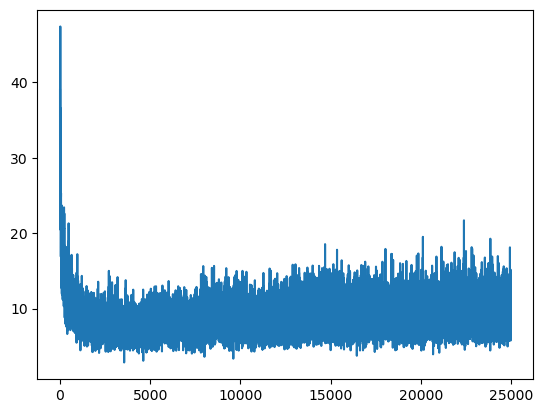

In [24]:
plt.plot([l.detach().numpy() for l in losses])

Text(0.5, 1.0, 'Evolution of Reward during training')

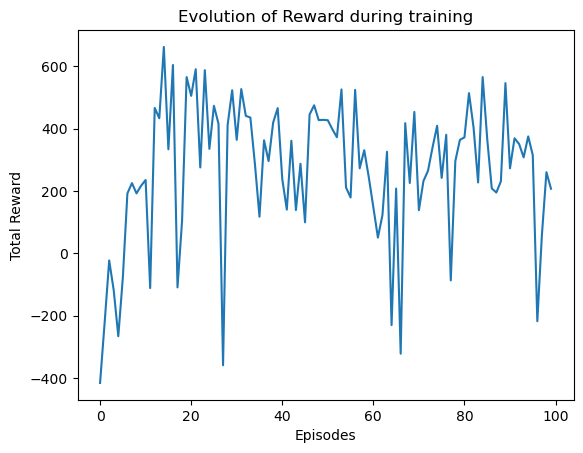

In [25]:
plt.plot(np.arange(len(rewards)), rewards)
plt.ylabel('Total Reward')
plt.xlabel('Episodes')
plt.title('Evolution of Reward during training')

## Train a PPO agent

In [22]:
import numpy as np 
import matplotlib.pyplot as plt 

from environment.env import SupplyChainPOC, SupplyChainV0
from agent.agent import BasicAgent, PPOAgent
from agent_trainer.main_trainer import PPOTrainer, normalize_obs
from vis import  visualization_factory

In [27]:
agent_PPO = PPOAgent(
        suppliers=suppliers, 
        obs_dim=4, 
        gamma=0.9
    )

rewards_PPO = PPOTrainer(
        agent=agent_PPO, 
        env=env, 
        suppliers=suppliers,
        nb_episode=1000, 
        episode_length=1000,
        nb_epochs=100
    )


Standard deviation:  tensor([[4.9442, 3.6738]], grad_fn=<MulBackward0>)
Mean:  tensor([[167.3242, 112.6004]], grad_fn=<MulBackward0>) 


Standard deviation:  tensor([[4.9459, 3.6733]], grad_fn=<MulBackward0>)
Mean:  tensor([[167.3299, 112.6045]], grad_fn=<MulBackward0>) 


Standard deviation:  tensor([[4.9442, 3.6750]], grad_fn=<MulBackward0>)
Mean:  tensor([[167.3630, 112.6084]], grad_fn=<MulBackward0>) 


Standard deviation:  tensor([[4.9485, 3.6800]], grad_fn=<MulBackward0>)
Mean:  tensor([[167.2607, 112.6810]], grad_fn=<MulBackward0>) 


Standard deviation:  tensor([[4.9441, 3.6758]], grad_fn=<MulBackward0>)
Mean:  tensor([[167.3548, 112.6151]], grad_fn=<MulBackward0>) 


Standard deviation:  tensor([[4.9454, 3.6794]], grad_fn=<MulBackward0>)
Mean:  tensor([[167.3631, 112.6521]], grad_fn=<MulBackward0>) 


Standard deviation:  tensor([[4.9453, 3.6723]], grad_fn=<MulBackward0>)
Mean:  tensor([[167.2953, 112.5957]], grad_fn=<MulBackward0>) 


Episode:  0
Sum of rewards:  -8819.92549

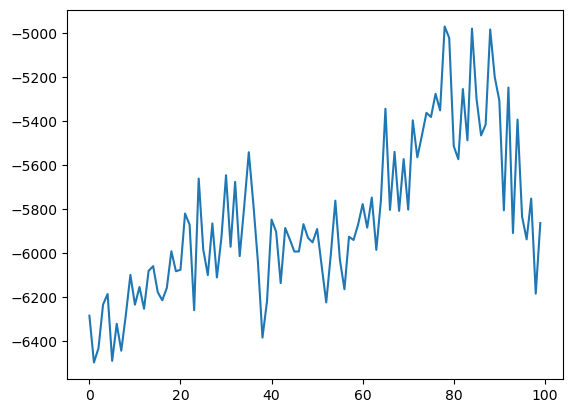

In [26]:
plt.plot(np.arange(len(rewards_PPO)), rewards_PPO)

In [58]:



reward_eval_dqn_list = []
profit_eval_dqn_list = []

for i in range(100):
    R = 0
    obs_eval, state_eval = env_eval.reset()
    terminated_eval = False
    profit_episode = []

    for _ in range(episode_length):

        with torch.no_grad():
            action_eval = torch.argmax(model(_handle_obs_dict(obs_eval))).item()
            action_eval = possible_actions[action_eval]

        obs_eval, reward_eval, profit_eval = env_eval.step({'distrib_'+str(k+1): action_eval[k] for k in range(n_distributors)})
        R += reward_eval
        profit_episode.append(profit_eval)
    reward_eval_dqn_list.append(R)
    profit_eval_dqn_list.append(profit_episode)


In [32]:
n_distributors = 2
suppliers = {
        'distrib_'+str(k+1): {
        "demand": 100, 
        "stock_max": 200, 
        "stock_cost": 3.,
        "lost_sell": 3., 
        "transport_cost": lambda x: 0.5*x, 
        "sell_price": 5.
    }
    for k in range(n_distributors)}
noises = np.arange(5, 500, 20)



In [33]:
len(noises)

25

In [36]:

n_distributors = 2
model = torch.load('DQN_'+str(n_distributors)+'_distributors.pt')
profit = {}
episode_length = 1000

for noise in noises:

    env_eval = SupplyChainV0(suppliers, 125*n_distributors, noise=noise)

    reward_eval_dqn_list = []
    profit_eval_dqn_list = []

    R = 0
    obs_eval, state_eval = env_eval.reset()
    terminated_eval = False
    profit_episode = []
    possible_actions = possible_actions_func(single_possible_actions, n_distributors)

    for _ in range(episode_length):

        with torch.no_grad():
            action_eval = torch.argmax(model(_handle_obs_dict(obs_eval))).item()
            action_eval = possible_actions[action_eval]

        obs_eval, reward_eval, profit_eval = env_eval.step({'distrib_'+str(k+1): action_eval[k] for k in range(n_distributors)})
        R += reward_eval
        profit_episode.append(profit_eval)
    reward_eval_dqn_list.append(R)
    profit_eval_dqn_list.append(profit_episode)

    profit[noise] = profit_episode

In [51]:
def moving_average(array, window):
    means = np.zeros(len(array) - window, dtype=np.float32)
    for i in range(len(array) - window):
        subarray = array[i:i+window]
        avg = np.sum(subarray)
        means[i] = avg
    return [np.mean(means), np.std(means)]

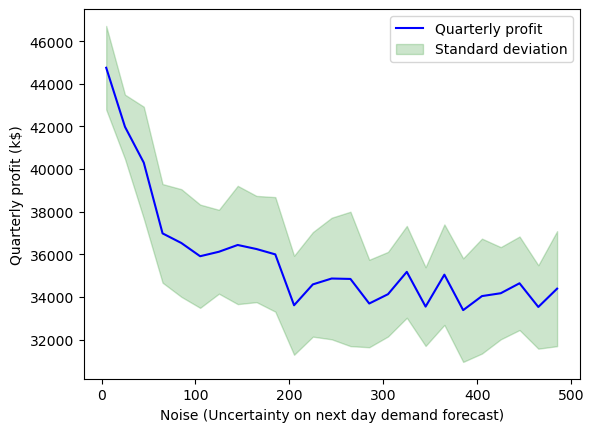

In [68]:
import matplotlib.pyplot as plt

indicator_list = np.array([moving_average(np.array(val), 90) for val in profit.values()])
std_array = indicator_list[:, 1]
mean_array = indicator_list[:, 0]


plt.plot(noises, mean_array, color='blue', label='Quarterly profit')
plt.fill_between(noises, mean_array-std_array, mean_array+std_array, alpha=0.2, color='green', label='Standard deviation')
plt.xlabel('Noise (Uncertainty on next day demand forecast)')
plt.ylabel('Quarterly profit (k$)')
plt.legend()

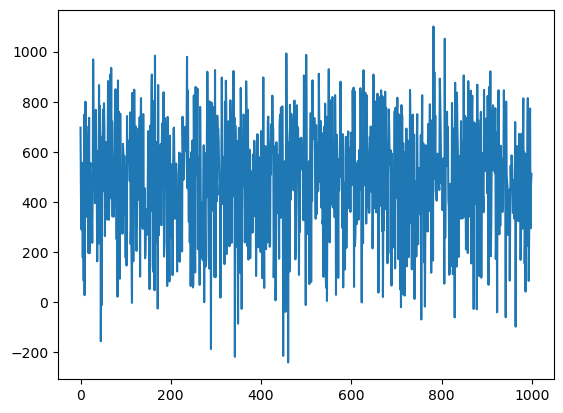

In [40]:
plt.plot(profit[5])

In [60]:
np.mean(np.sum(np.array(profit_eval_dqn_list), axis=1))

576667.2188173292